In [509]:
import sys
import os
import numpy as np
import pyBigWig
import matplotlib.pyplot as plt
from scipy.stats import poisson, binom, norm
from tqdm.notebook import tqdm

# Append the parent directory to sys.path
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)
from utils.bw_loader import bigwig_to_arrays_by_chrom

In [527]:
(norm.sf(0.23,loc=0.00871755352403843,scale=0.01769072541409001))

3.358705499041573e-36

In [ ]:
from pomegranate import BetaDistribution, State, PoissonDistribution, NormalDistribution, GeneralMixtureModel, HiddenMarkovModel

In [297]:
ctcf_chr1_path = '/global/scratch/users/dixonluinenburg/whole_genome_bigwigs/GM12878_CTCF_deep/chr1'
ctcf_chr14_path = '/global/scratch/users/dixonluinenburg/whole_genome_bigwigs/GM12878_CTCF_deep/chr2'
# hia5_path = '/global/scratch/users/dixonluinenburg/whole_genome_bigwigs/Hia5-free/chr1'

In [149]:
ctcf_bedfile = '/global/scratch/projects/vector_streetslab/jmarcus/dimelo_data/CTCF.motifs.known.chm13v1.1.bed'

In [298]:
chr1_motifs = []
chr14_motifs = []
with open(ctcf_bedfile) as f:
    for line in f:
        if (line.split('\t')[0]=='chr1'):
            chr1_motifs.append(int(line.split('\t')[1]))
        if (line.split('\t')[0]=='chr2'):
            chr14_motifs.append(int(line.split('\t')[1]))

In [299]:
chip_bedfile = '/clusterfs/nilah/oberon/datasets/ctcf_peaks/ENCFF797SDL.chm13v1.1.bed'

In [300]:
chr1_chip_peaks = []
chr14_chip_peaks = []
with open(chip_bedfile) as f:
    for line in f:
        if (line.split('\t')[0]=='chr1'):
            chr1_chip_peaks.append(int(line.split('\t')[1]))
        if (line.split('\t')[0]=='chr2'):
            chr14_chip_peaks.append(int(line.split('\t')[1]))

In [301]:
chr1_motifs_array = np.array(chr1_motifs)
chr14_motifs_array = np.array(chr14_motifs)

In [302]:
chr1_chip_array = np.array(chr1_chip_peaks)
chr14_chip_array = np.array(chr14_chip_peaks)

In [303]:
print(np.sort(chr1_motifs_array))

[    12946     30618     30619 ... 248345177 248363694 248363695]


In [304]:
print(np.sort(chr1_chip_array))

[   205245    298724    334494 ... 248297048 248344799 248363390]


In [336]:
train_start_co = 0_000_000
train_end_co = 50_000_000
train_valid_array,train_mod_array = bigwig_to_arrays_by_chrom(ctcf_chr1_path,'ctcf_deep_','mA','chr1',train_start_co,train_end_co)

In [324]:
test_start_co = 0_000_000
test_end_co = 240_000_000
test_valid_array,test_mod_array = bigwig_to_arrays_by_chrom(ctcf_chr14_path,'ctcf_deep_','mA','chr2',test_start_co,test_end_co)

In [337]:
print(np.sum(mod_array)/np.sum(valid_array))

0.008641771116667338


In [338]:
bin_size = 50
bins = np.arange(0,train_end_co-train_start_co,bin_size)
test_bins = np.arange(0,test_end_co-test_start_co,bin_size)

In [339]:
train_mod_data = np.nan_to_num(np.add.reduceat(train_mod_array,bins))
train_valid_data = np.nan_to_num(np.add.reduceat(train_valid_array,bins))
test_mod_data = np.nan_to_num(np.add.reduceat(test_mod_array,test_bins))
test_valid_data = np.nan_to_num(np.add.reduceat(test_valid_array,test_bins))

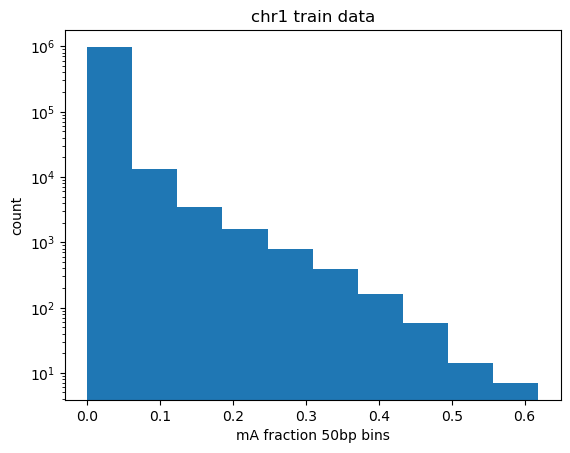

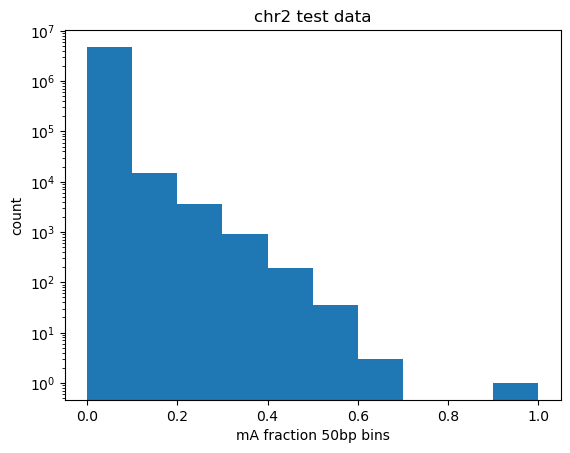

In [430]:
plt.hist((train_mod_data+0.0000001)/(train_valid_data+0.0001))
plt.yscale('log')
plt.title('chr1 train data')
plt.xlabel(f'mA fraction {bin_size}bp bins')
plt.ylabel('count')
plt.show()
plt.hist((test_mod_data+0.0000001)/(test_valid_data+0.0001))
plt.yscale('log')
plt.title('chr2 test data')
plt.xlabel(f'mA fraction {bin_size}bp bins')
plt.ylabel('count')
plt.show()

In [341]:
list_of_train_sequences = []
list_of_train_startcos = []
sequence_length = 1000
for i in range((train_end_co-train_start_co)//(bin_size*sequence_length)):
#     mod_data_subset = (mod_data[1000*i:1000*i+1000])[((valid_data>0) & (mod_data>0))[1000*i:1000*i+1000]]
#     valid_data_subset = (valid_data[1000*i:1000*i+1000])[((valid_data>0) & (mod_data>0))[1000*i:1000*i+1000]]
#     print(len(valid_data_subset))
#     list_of_sequences.append(mod_data[1000*i:1000*i+1000])+0.0000001
    list_of_train_startcos.append(sequence_length*bin_size*i + train_start_co)
    list_of_train_sequences.append((train_mod_data[sequence_length*i:sequence_length*i+sequence_length]+0.0000001)
                             /(train_valid_data[sequence_length*i:sequence_length*i+sequence_length]+0.0001))

In [342]:
list_of_test_sequences = []
list_of_test_startcos = []
for i in range((test_end_co-test_start_co)//(bin_size*sequence_length)):
    list_of_test_startcos.append(sequence_length*bin_size*i + test_start_co)
    list_of_test_sequences.append((test_mod_data[sequence_length*i:sequence_length*i+sequence_length]+0.0000001)
                             /(test_valid_data[sequence_length*i:sequence_length*i+sequence_length]+0.0001))

In [343]:
# p_values = []
# for i in range(len(mod_data)):
#     p_values.append(1-binom.cdf(mod_data[i],valid_data[i],0.00845))

In [344]:
# p_values_array = np.array(p_values)

In [345]:
# plt.plot(np.arange(100000,200000),p_values_array<1e-10)
# plt.semilogy()
# plt.axis([120000,122000,0,1])

In [23]:
# plt.plot(np.arange(10000,20000),mod_data / valid_data)
# plt.axis([12000,12200,0,1])

In [24]:
# beta_background = BetaDistribution(0.2,40)
# beta_peak = BetaDistribution(10,400)

In [78]:
# for sequence in list_of_sequences:
#     plt.hist(sequence)
#     plt.yscale('log')
#     plt.show()
#     break
# #     beta_background.fit((mod_data+0.01)/(valid_data+0.01))
# #     plt.hist(beta_background.sample(n=3000))
#     plt.show()
#     print(beta_background.parameters)
# #     print(sequence)
#     beta_background.fit(sequence)
#     print(beta_background.parameters)


[208.0, 9792.0]


In [79]:
# plt.hist(beta_background.sample(n=10000))
# plt.hist(beta_peak.sample(n=10000))

In [398]:
state1 = State(NormalDistribution(0,0.01),name='background')
state2 = State(NormalDistribution(0.05,0.04),name='accessible')
model = HiddenMarkovModel(name='CTCF_Peaks')

In [399]:
state3.distribution.freeze()

In [400]:
model.add_transition(model.start,state1,0.9)
model.add_transition(model.start,state2,0.098)
model.add_transition(model.start,state3,0.002)
model.add_transition(state1, state1, 0.9)       # transition probability from state1 to state1
model.add_transition(state1, state2, 0.08)       # transition probability from state1 to state2
model.add_transition(state1, state3, 0.02)
model.add_transition(state2, state1, 0.05)       # transition probability from state2 to state1
model.add_transition(state2, state2, 0.9)
model.add_transition(state2, state3, 0.05)
model.add_transition(state3, state1, 0.2)       # transition probability from state2 to state1
model.add_transition(state3, state2, 0.3)
model.add_transition(state3, state3, 0.5)
model.add_transition(state1, model.end, 0.1)    # transition probability from state1 to end
model.add_transition(state2, model.end, 0.1)    # transition probability from state2 to end
model.add_transition(state3, model.end, 0.1)    # transition probability from state1 to end

In [401]:
model.bake()

In [402]:
model.fit(list_of_train_sequences,max_iterations=100,stop_threshold=0.001)

{
    "class" : "HiddenMarkovModel",
    "name" : "CTCF_Peaks",
    "start" : {
        "class" : "State",
        "distribution" : null,
        "name" : "CTCF_Peaks-start",
        "weight" : 1.0
    },
    "end" : {
        "class" : "State",
        "distribution" : null,
        "name" : "CTCF_Peaks-end",
        "weight" : 1.0
    },
    "states" : [
        {
            "class" : "State",
            "distribution" : {
                "class" : "Distribution",
                "name" : "NormalDistribution",
                "parameters" : [
                    0.021735014617387336,
                    0.02458546474489636
                ],
                "frozen" : false
            },
            "name" : "accessible",
            "weight" : 1.0
        },
        {
            "class" : "State",
            "distribution" : {
                "class" : "Distribution",
                "name" : "NormalDistribution",
                "parameters" : [
                    0.001665767

In [403]:
with open('ctcf_model_freeze-peak','w') as f:
    f.write(model.to_json())

In [507]:
# State orders in pomegranate get moved around so we need to reference the state names
state_map_dict = {}
for idx,state in enumerate(model.states):
    if state.name=='background':
        state_map_dict[idx]=0
    elif state.name=='accessible':
        state_map_dict[idx]=1
    elif state.name=='ctcf':
        state_map_dict[idx]=2
print(state_map_dict)
num_plots = 100
total_stat_test_peaks = 0
stat_window = 5
p_thresh = 1e-110
total_ctcf_peaks = 0
total_chip_peaks = 0
matched_ctcf_peaks = 0
matches_chip_peaks = 0
allowable_distance_between_peaks = 2000
for idx,sequence in enumerate(list_of_train_sequences):
    sub_startco = list_of_train_startcos[idx]
    sub_endco = sub_startco + 1000*bin_size
    inframe_motifs = chr1_motifs_array[((chr1_motifs_array>sub_startco) & (chr1_motifs_array<sub_endco))]
    inframe_chip = chr1_chip_array[((chr1_chip_array>sub_startco) & (chr1_chip_array<sub_endco))]

    state_sequence = model.predict(sequence)
    log_prob = model.log_probability(sequence)
    
    # Find ctcf peak coordinates for dimelo calls
    inframe_dimelo = sub_startco+np.where(np.array([state_map_dict[state]==2 for state in state_sequence]))[0]*bin_size

    inframe_stat_test = sub_startco+np.where(np.array([(binom.sf(sequence[i]*450,450,0.008)) for i in range(len(sequence))])<p_thresh)[0]*bin_size
    
    for dimelo_peak in inframe_dimelo:
        if len(inframe_chip[((inframe_chip>dimelo_peak-allowable_distance_between_peaks) 
                            & (inframe_chip<dimelo_peak+allowable_distance_between_peaks))])>0:
            matched_ctcf_peaks+=1
    
    total_stat_test_peaks += len(inframe_stat_test)
    total_ctcf_peaks += len(inframe_dimelo)
#     np.sum(np.array([((state_map_dict[state])==2) for state in state_sequence]))
    total_chip_peaks += len(inframe_chip)
#     state_names = [model.states[index].name for index in state_sequence]
#     plt.plot(state_sequence)
#     plt.plot([max(state_map_dict[state]-1,0) for state in state_sequence],".")
#     print(sequence*30*25)
#     print(np.array([(1-binom.cdf(sequence[i]*30*25,30*25,0.00845)) for i in range(len(sequence))])<1e-6)
#     plt.plot(np.array([(1-binom.cdf(sequence[i]*30*25,30*25,0.00845)) for i in range(len(sequence))])<1e-7,'--')
    
#     plt.plot(sequence,alpha=0.2)
#     for motif_coord in inframe_motifs:
#         plt.axvline(x=(motif_coord-sub_startco)/bin_size,color='r',linestyle='--')
#     for chip_coord in inframe_chip:
#         plt.axvline(x=(chip_coord-sub_startco)/bin_size,color='k',linestyle='--')
#     plt.show()
#     print("Most likely sequence of states:", state_sequence)
#     print("Log probability of the sequence:", log_prob)
#     print()
    if idx>num_plots:
        print('reached lim')
        break
print('hmm:',total_ctcf_peaks,'hmm matching ChIP',matched_ctcf_peaks,f'\nbinom {p_thresh}:',total_stat_test_peaks,'total chIP',total_chip_peaks)

{0: 1, 1: 0, 2: 2}
reached lim
hmm: 226 hmm matching ChIP 103 
binom 1e-110: 242 total chIP 111


In [523]:
# State orders in pomegranate get moved around so we need to reference the state names
state_map_dict = {}
for idx,state in enumerate(model.states):
    if state.name=='background':
        state_map_dict[idx]=0
    elif state.name=='accessible':
        state_map_dict[idx]=1
    elif state.name=='ctcf':
        state_map_dict[idx]=2
print(state_map_dict)
num_plots = 20000
total_ctcf_peaks = 0
total_chip_peaks = 0
matched_ctcf_hmm_peaks = 0
matched_ctcf_stat_peaks = 0
matches_chip_peaks = 0
total_stat_test_peaks = 0
allowable_distance_between_peaks = 2000
effective_threshold = 0.23
make_plots = False
for idx,sequence in tqdm(enumerate(list_of_test_sequences)):
    sub_startco = list_of_test_startcos[idx]
    sub_endco = sub_startco + sequence_length*bin_size
    inframe_motifs = chr14_motifs_array[((chr14_motifs_array>sub_startco) & (chr14_motifs_array<sub_endco))]
    inframe_chip = chr14_chip_array[((chr14_chip_array>sub_startco) & (chr14_chip_array<sub_endco))]

    state_sequence = model.predict(sequence)
    log_prob = model.log_probability(sequence)
    
    # Find ctcf peak coordinates for dimelo calls
    
    inframe_dimelo = sub_startco+np.where(np.array([state_map_dict[state]==2 for state in state_sequence]))[0]*bin_size
    
    inframe_stat_test = sub_startco+np.where(np.array(sequence)>effective_threshold)[0]
    total_stat_test_peaks += len(inframe_stat_test)
    
    for dimelo_peak in inframe_dimelo:
        if len(inframe_chip[((inframe_chip>dimelo_peak-allowable_distance_between_peaks) 
                            & (inframe_chip<dimelo_peak+allowable_distance_between_peaks))])>0:
            matched_ctcf_hmm_peaks+=1
            
    for dimelo_peak in inframe_stat_test:
        if len(inframe_chip[((inframe_chip>dimelo_peak-allowable_distance_between_peaks) 
                            & (inframe_chip<dimelo_peak+allowable_distance_between_peaks))])>0:
            matched_ctcf_stat_peaks+=1
    
    total_ctcf_peaks += len(inframe_dimelo)
    total_chip_peaks += len(inframe_chip)
    
    if make_plots:
    
        x_axis = np.arange(sub_startco,sub_endco,bin_size)

        plt.title('chr2 dimelo peaks (HMM trained on chr1)\nRoughly matching overall ChIP-seq peak counts')
        plt.ylabel('mA/A')
        plt.xlabel('coordinate on chromosome')
        
        plt.plot(x_axis,[max(state_map_dict[state]-1,0)*0.4 for state in state_sequence],".",label='hmm peak calls')
    #     print(sequence*30*25)
    #     print(np.array([(1-binom.cdf(sequence[i]*30*25,30*25,0.00845)) for i in range(len(sequence))])<1e-6)
    #     plt.plot(np.array([(1-binom.cdf(sequence[i]*30*25,30*25,0.00845)) for i in range(len(sequence))])<1e-7,'--')

        plt.plot(x_axis,sequence,alpha=0.4,label='dimelo raw trace')
        for motif_coord in inframe_motifs:
            plt.axvline(x=(motif_coord-sub_startco),color='r',linestyle='--')
        for chip_coord in inframe_chip:
            plt.axvline(x=(chip_coord),color='k',linestyle='--',alpha=0.4)
        plt.axis([sub_startco,sub_endco,0,0.5])
        plt.axvline(x=0,color='k',linestyle='--',alpha=0.4,label='ChIP peak call (published)')
        plt.legend()
        plt.show()
    #     print("Most likely sequence of states:", state_sequence)
    #     print("Log probability of the sequence:", log_prob)
    #     print()
    if idx>num_plots:
        print('reached lim')
        break
print(total_ctcf_peaks,matched_ctcf_hmm_peaks,'\n',total_stat_test_peaks,matched_ctcf_stat_peaks,'\n',total_chip_peaks)

{0: 1, 1: 0, 2: 2}


0it [00:00, ?it/s]

3209 1509 
 3188 244 
 3147


In [522]:
print(total_stat_test_peaks)

3188


In [462]:
state4 = State(NormalDistribution(0,0.01),name='background')
# state5 = State(NormalDistribution(0.05,0.04),name='accessible')
state6 = State(NormalDistribution(0.55,0.04),name='ctcf')
model2 = HiddenMarkovModel(name='CTCF_Peaks_no-freeze')

In [463]:
model2.add_transition(model2.start,state4,0.998)
# model2.add_transition(model2.start,state5,0.098)
model2.add_transition(model2.start,state6,0.002)
model2.add_transition(state4, state4, 0.9)       # transition probability from state1 to state1
# model2.add_transition(state4, state5, 0.08)       # transition probability from state1 to state2
model2.add_transition(state4, state6, 0.02)
# model2.add_transition(state5, state4, 0.05)       # transition probability from state2 to state1
# model2.add_transition(state5, state5, 0.9)
# model2.add_transition(state5, state6, 0.05)
model2.add_transition(state6, state4, 0.2)       # transition probability from state2 to state1
# model2.add_transition(state6, state5, 0.3)
model2.add_transition(state6, state6, 0.5)
model2.add_transition(state4, model2.end, 0.1)    # transition probability from state1 to end
# model2.add_transition(state5, model2.end, 0.1)    # transition probability from state2 to end
model2.add_transition(state6, model2.end, 0.1)    # transition probability from state1 to end

In [464]:
model2.bake()

In [465]:
model2.fit(list_of_train_sequences,max_iterations=100,stop_threshold=0.001)

{
    "class" : "HiddenMarkovModel",
    "name" : "CTCF_Peaks_no-freeze",
    "start" : {
        "class" : "State",
        "distribution" : null,
        "name" : "CTCF_Peaks_no-freeze-start",
        "weight" : 1.0
    },
    "end" : {
        "class" : "State",
        "distribution" : null,
        "name" : "CTCF_Peaks_no-freeze-end",
        "weight" : 1.0
    },
    "states" : [
        {
            "class" : "State",
            "distribution" : {
                "class" : "Distribution",
                "name" : "NormalDistribution",
                "parameters" : [
                    0.00281866278777802,
                    0.003937007475890527
                ],
                "frozen" : false
            },
            "name" : "background",
            "weight" : 1.0
        },
        {
            "class" : "State",
            "distribution" : {
                "class" : "Distribution",
                "name" : "NormalDistribution",
                "parameters" : [
 

In [466]:
with open('ctcf_model_no-freeze','w') as f:
    f.write(model2.to_json())

In [524]:
# State orders in pomegranate get moved around so we need to reference the state names
state_map_dict = {}
for idx,state in enumerate(model2.states):
    if state.name=='background':
        state_map_dict[idx]=0
    elif state.name=='accessible':
        state_map_dict[idx]=1
    elif state.name=='ctcf':
        state_map_dict[idx]=2
print(state_map_dict)
num_plots = 200000
total_ctcf_peaks = 0
total_chip_peaks = 0
matched_ctcf_peaks = 0
matches_chip_peaks = 0
allowable_distance_between_peaks = 2000
make_plots = False
for idx,sequence in enumerate(list_of_test_sequences):
    sub_startco = list_of_test_startcos[idx]
    sub_endco = sub_startco + sequence_length*bin_size
    inframe_motifs = chr14_motifs_array[((chr14_motifs_array>sub_startco) & (chr14_motifs_array<sub_endco))]
    inframe_chip = chr14_chip_array[((chr14_chip_array>sub_startco) & (chr14_chip_array<sub_endco))]

    state_sequence = model2.predict(sequence)
#     print(state_sequence)
    log_prob = model.log_probability(sequence)
    
    # Find ctcf peak coordinates for dimelo calls
    
    inframe_dimelo = sub_startco+np.where(np.array([state_map_dict[state]==2 for state in state_sequence]))[0]*bin_size
    
    for dimelo_peak in inframe_dimelo:
        if len(inframe_chip[((inframe_chip>dimelo_peak-allowable_distance_between_peaks) 
                            & (inframe_chip<dimelo_peak+allowable_distance_between_peaks))])>0:
            matched_ctcf_peaks+=1
    
    total_ctcf_peaks += len(inframe_dimelo)
    total_chip_peaks += len(inframe_chip)
    
    if make_plots:
    
        x_axis = np.arange(sub_startco,sub_endco,bin_size)

        plt.title('chr2 dimelo peaks (HMM trained on chr1)\nRoughly matching overall ChIP-seq peak counts')
        plt.ylabel('mA/A')
        plt.xlabel('coordinate on chromosome')
        
        plt.plot(x_axis,[max(state_map_dict[state]-1,0)*0.4 for state in state_sequence],".",label='hmm peak calls')
    #     print(sequence*30*25)
    #     print(np.array([(1-binom.cdf(sequence[i]*30*25,30*25,0.00845)) for i in range(len(sequence))])<1e-6)
    #     plt.plot(np.array([(1-binom.cdf(sequence[i]*30*25,30*25,0.00845)) for i in range(len(sequence))])<1e-7,'--')

        plt.plot(x_axis,sequence,alpha=0.4,label='dimelo raw trace')
    #     for motif_coord in inframe_motifs:
    #         plt.axvline(x=(motif_coord-sub_startco)/bin_size,color='r',linestyle='--')
        for chip_coord in inframe_chip:
            plt.axvline(x=(chip_coord),color='k',linestyle='--',alpha=0.4)
        plt.axis([sub_startco,sub_endco,0,0.5])
        plt.axvline(x=0,color='k',linestyle='--',alpha=0.4,label='ChIP peak call (published)')
        plt.legend()
        plt.show()
    #     print("Most likely sequence of states:", state_sequence)
    #     print("Log probability of the sequence:", log_prob)
    #     print()
    if idx>num_plots:
        print('reached lim')
        break
print(total_ctcf_peaks,matched_ctcf_peaks,total_chip_peaks)

{0: 0, 1: 2}
757429 115841 3147


In [449]:
state7 = State(NormalDistribution(0,0.01),name='background')
state8 = State(NormalDistribution(0.73,0.04),name='ctcf')
model3 = HiddenMarkovModel(name='CTCF_Peaks_two-state')
state8.distribution.freeze()

In [450]:
model3.add_transition(model3.start,state7,0.98)
model3.add_transition(model3.start,state8,0.002)
model3.add_transition(state7, state7, 0.98)       # transition probability from state1 to state1
model3.add_transition(state7, state8, 0.02)
model3.add_transition(state8, state7, 0.1)       # transition probability from state2 to state1
model3.add_transition(state8, state8, 0.9)
model3.add_transition(state7, model3.end, 0.1)    # transition probability from state1 to end
model3.add_transition(state8, model3.end, 0.1)    # transition probability from state2 to end

In [451]:
model3.bake()

In [452]:
model3.fit(list_of_train_sequences,max_iterations=100,stop_threshold=0.001)

{
    "class" : "HiddenMarkovModel",
    "name" : "CTCF_Peaks_two-state",
    "start" : {
        "class" : "State",
        "distribution" : null,
        "name" : "CTCF_Peaks_two-state-start",
        "weight" : 1.0
    },
    "end" : {
        "class" : "State",
        "distribution" : null,
        "name" : "CTCF_Peaks_two-state-end",
        "weight" : 1.0
    },
    "states" : [
        {
            "class" : "State",
            "distribution" : {
                "class" : "Distribution",
                "name" : "NormalDistribution",
                "parameters" : [
                    0.00871755352403843,
                    0.01769072541409001
                ],
                "frozen" : false
            },
            "name" : "background",
            "weight" : 1.0
        },
        {
            "class" : "State",
            "distribution" : {
                "class" : "Distribution",
                "name" : "NormalDistribution",
                "parameters" : [
  

In [453]:
with open('ctcf_model_two-state','w') as f:
    f.write(model3.to_json())

In [525]:
# State orders in pomegranate get moved around so we need to reference the state names
state_map_dict = {}
for idx,state in enumerate(model3.states):
    if state.name=='background':
        state_map_dict[idx]=0
    elif state.name=='accessible':
        state_map_dict[idx]=1
    elif state.name=='ctcf':
        state_map_dict[idx]=2
print(state_map_dict)
num_plots = 10000
total_ctcf_peaks = 0
total_chip_peaks = 0
matched_ctcf_peaks = 0
matches_chip_peaks = 0
allowable_distance_between_peaks = 2000
make_plots = False
for idx,sequence in enumerate(list_of_test_sequences):
    sub_startco = list_of_test_startcos[idx]
    sub_endco = sub_startco + sequence_length*bin_size
    inframe_motifs = chr14_motifs_array[((chr14_motifs_array>sub_startco) & (chr14_motifs_array<sub_endco))]
    inframe_chip = chr14_chip_array[((chr14_chip_array>sub_startco) & (chr14_chip_array<sub_endco))]

    state_sequence = model3.predict(sequence)
    log_prob = model.log_probability(sequence)
    
    # Find ctcf peak coordinates for dimelo calls
    
    inframe_dimelo = sub_startco+np.where(np.array([state_map_dict[state]==2 for state in state_sequence]))[0]*bin_size
    
    for dimelo_peak in inframe_dimelo:
        if len(inframe_chip[((inframe_chip>dimelo_peak-allowable_distance_between_peaks) 
                            & (inframe_chip<dimelo_peak+allowable_distance_between_peaks))])>0:
            matched_ctcf_peaks+=1
    
    total_ctcf_peaks += len(inframe_dimelo)
    total_chip_peaks += len(inframe_chip)
    
    if make_plots:
    
        x_axis = np.arange(sub_startco,sub_endco,bin_size)

        plt.title('chr2 dimelo peaks (HMM trained on chr1)\nRoughly matching overall ChIP-seq peak counts')
        plt.ylabel('mA/A')
        plt.xlabel('coordinate on chromosome')
        
        plt.plot(x_axis,[max(state_map_dict[state]-1,0)*0.4 for state in state_sequence],".",label='hmm peak calls')
    #     print(sequence*30*25)
    #     print(np.array([(1-binom.cdf(sequence[i]*30*25,30*25,0.00845)) for i in range(len(sequence))])<1e-6)
    #     plt.plot(np.array([(1-binom.cdf(sequence[i]*30*25,30*25,0.00845)) for i in range(len(sequence))])<1e-7,'--')

        plt.plot(x_axis,sequence,alpha=0.4,label='dimelo raw trace')
    #     for motif_coord in inframe_motifs:
    #         plt.axvline(x=(motif_coord-sub_startco)/bin_size,color='r',linestyle='--')
        for chip_coord in inframe_chip:
            plt.axvline(x=(chip_coord),color='k',linestyle='--',alpha=0.4)
        plt.axis([sub_startco,sub_endco,0,0.5])
        plt.axvline(x=0,color='k',linestyle='--',alpha=0.4,label='ChIP peak call (published)')
        plt.legend()
        plt.show()
    #     print("Most likely sequence of states:", state_sequence)
    #     print("Log probability of the sequence:", log_prob)
    #     print()
    if idx>num_plots:
        print('reached lim')
        break
print(total_ctcf_peaks,matched_ctcf_peaks,total_chip_peaks)

{0: 0, 1: 2}
2988 1399 3147
